In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as sm

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [3]:
url = 'https://raw.githubusercontent.com/Jneny/Hospitalcapacity/main/Data/icu_beds.csv'
data = read_csv(url, header=0, parse_dates=[0], index_col=0)
data = data.asfreq('d')
adultcrit = pd.DataFrame(data, columns=['adult_icu_crci_patients'])
sadultcrit = pd.Series(adultcrit.adult_icu_crci_patients)

We will be training the model with a train/test split for predicting the last quarter of 3 months which is calculated in terms of weeks so 7*4*3 = 84 days for the test and 655- 84 = 571 for the train portion.

train a model by using the autocorrelation integrated moving average (ARIMA) model on 571 of the dataset to 
measure events that happen over a period of time
how much correlation there is in it's influence on the current point 
measures how well past values(amt of patients) predict current values
the goal of the model is to forecast the amount of beds needed in latter three months of the dataset  

In [4]:
# size = int(len(adultcrit)*.8)
size = 571
adtrain = adultcrit.iloc[:size]
adtest = adultcrit.iloc[size:]

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
#Check stationarity of train set - not stationary
adfuller(adtrain['adult_icu_crci_patients'].dropna()) 

(-2.3956581788414826,
 0.14296560749091403,
 17,
 553,
 {'1%': -3.4422304958001386,
  '5%': -2.866780664287393,
  '10%': -2.5695611022893377},
 3635.2462228399218)

The two methods of making the data stationary was tested, one by differencing before modelling, auto arima was actually ARMA since d = 1 was pre-processed
1. Differencing first then using auto arima -> gave (1,0,1) ARMA, AIC = 3489.560
2. Directly using auto arima with train set -> gave (1,1,1) ARIMA of integration 1, AIC = 3487.595
The second method results had a slightly higher AIC score so directly using auto arima on train was the better method by 1.965.

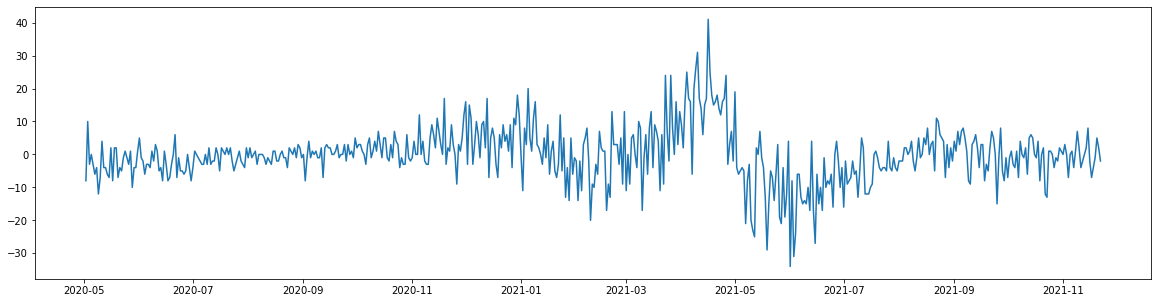

In [7]:
adcdiff = adtrain.adult_icu_crci_patients.diff()
plt.plot(adcdiff)

In [8]:
adfuller(adcdiff.dropna())
#is now stationary pvalue  0.0158

(-3.279997708180158,
 0.015796598724007918,
 16,
 553,
 {'1%': -3.4422304958001386,
  '5%': -2.866780664287393,
  '10%': -2.5695611022893377},
 3633.5785097462644)

In [9]:
#Finding order for arima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [10]:
#show step-by-step as auto arima finds best values for (p,d,q)
stepwise_fit = auto_arima(adcdiff[1:], trace = True, supress_warnings = True)
stepwise_fit.summary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3781.423, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4026.836, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3892.046, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3943.971, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4025.165, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3779.361, Time=0.46 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3899.461, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3777.427, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3779.364, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3847.551, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3775.452, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3942.209, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3890.186, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3777.389, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]          

<function pmdarima.arima.arima.ARIMA.summary(self)>

In [11]:
#use the found order in the actual arima on train data
import statsmodels.api as sm

In [12]:
model = sm.tsa.arima.ARIMA(adcdiff[1:], order = (1,0,1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     adult_icu_crci_patients   No. Observations:                  570
Model:                      ARIMA(1, 0, 1)   Log Likelihood               -1884.714
Date:                     Wed, 06 Apr 2022   AIC                           3777.427
Time:                             22:42:32   BIC                           3794.810
Sample:                         05-02-2020   HQIC                          3784.209
                              - 11-22-2021                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2982      1.926     -0.155      0.877      -4.074       3.477
ar.L1          0.9737      0.009    106.007      0.000       0.956       0.992
ma.L1         -0.8078      0.023    -35.853      0.000      -0.852      -0.764
sigma2        43.5352      1.899     22.927      0.000      39.814      47.257
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                88.03
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               3.53   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Check fit of model on train

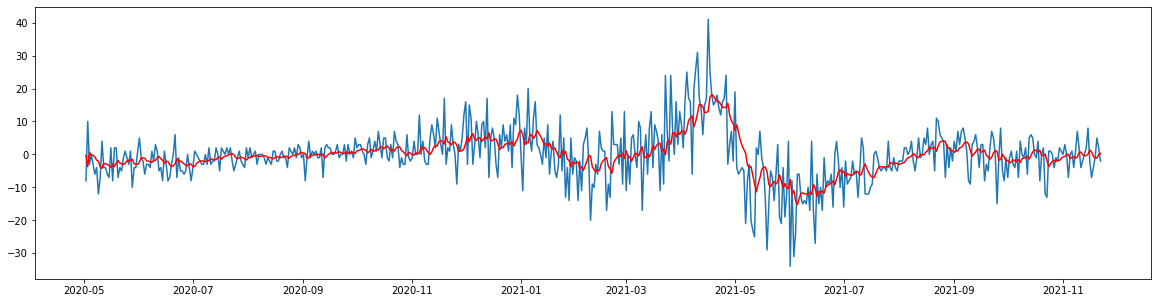

In [13]:
plt.plot(adcdiff)
plt.plot(result.fittedvalues, color = 'red')

Method # 2 directly using arima on train

In [14]:
stepwise_fit_whole = auto_arima(adtrain, trace = True, supress_warnings = True)
stepwise_fit_whole.summary

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3781.424, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4026.836, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3892.048, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3943.973, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4025.165, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3779.362, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3899.461, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3777.428, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3779.365, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3847.551, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3775.453, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3942.210, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3890.188, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3777.390, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<function pmdarima.arima.arima.ARIMA.summary(self)>

Shows order (1,1,1) same order as method 1 but the differencing will be automatically done

In [15]:
model_whole = sm.tsa.arima.ARIMA(adtrain, order = (1,1,1))
result_whole = model_whole.fit()
result_whole.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     adult_icu_crci_patients   No. Observations:                  571
Model:                      ARIMA(1, 1, 1)   Log Likelihood               -1884.726
Date:                     Wed, 06 Apr 2022   AIC                           3775.453
Time:                             22:42:38   BIC                           3788.490
Sample:                         05-01-2020   HQIC                          3780.539
                              - 11-22-2021                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9737      0.009    106.688      0.000       0.956       0.992
ma.L1         -0.8077      0.022    -36.347      0.000      -0.851      -0.764
sigma2        43.5350      1.894     22.981      0.000      39.822      47.248
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                87.92
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               3.53   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

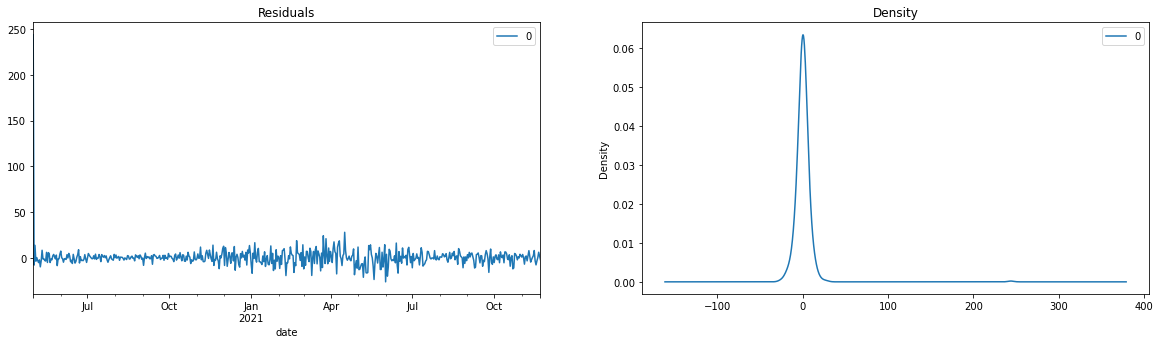

In [16]:
#Examine for 0 mean and variance
residuals = pd.DataFrame(result_whole.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

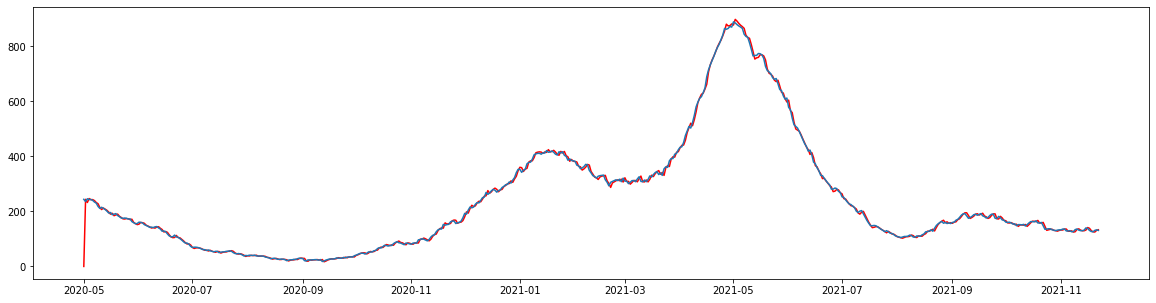

In [17]:
# Actual vs Fitted of model on train set
act_and_fitt = result_whole.predict(dynamic=False)
plt.plot(act_and_fitt, color = 'red')
plt.plot(adtrain)

In [18]:
sadtest = pd.Series(adtest.adult_icu_crci_patients, copy = True)

Note that plot_predict does not work on statsmodels version: 0.13.2 so will be using statsmodels 0.11.1 for the prediction in a separate notebook.

## For Prediction Go to separate notebook